# RF/DN Figures for CC18 Data Set Suite

In [1]:
# Import required packages
import numpy as np
import matplotlib as mpl
from matplotlib.ticker import NullFormatter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from tqdm.notebook import tqdm
import openml

In [2]:
def load_result(filename):
    """
    Loads results from specified file
    """
    return np.loadtxt(filename)


def read_params_txt(filename):
    """
    Read in tuned hyperparameters from text file
    """
    params = []
    f = open(filename, "r").read()
    f = f.split("\n")
    f = f[:-1]
    for ind, i in enumerate(f):
        temp = ast.literal_eval(f[ind])
        params.append(temp)
    return params


def load_cc18():
    """
    Import datasets from OpenML-CC18 dataset suite
    """
    X_data_list = []
    y_data_list = []
    dataset_name = []

    for task_num, task_id in enumerate(
        tqdm(openml.study.get_suite("OpenML-CC18").tasks)
    ):
        try:
            successfully_loaded = True
            dataset = openml.datasets.get_dataset(
                openml.tasks.get_task(task_id).dataset_id
            )
            dataset_name.append(dataset.name)
            X, y, is_categorical, _ = dataset.get_data(
                dataset_format="array", target=dataset.default_target_attribute
            )
            _, y = np.unique(y, return_inverse=True)
            X = np.nan_to_num(X)
        except TypeError:
            successfully_loaded = False
        if successfully_loaded and np.shape(X)[1] > 0:
            X_data_list.append(X)
            y_data_list.append(y)

    return X_data_list, y_data_list, dataset_name

In [3]:
# Load model performances across range of sample sizes
full_dataset_rf_scores_kappa = load_result("results/cc18_rf_kappa.txt")
full_dataset_dn_scores_kappa = load_result("results/cc18_dn_kappa.txt")
full_dataset_rf_scores_ece = load_result("results/cc18_rf_ece.txt")
full_dataset_dn_scores_ece = load_result("results/cc18_dn_ece.txt")

# Load model wall times
rf_times_train = load_result("results/cc18_rf_times_train.txt")
rf_times_test = load_result("results/cc18_rf_times_test.txt")
dn_times_train = load_result("results/cc18_dn_times_train.txt")
dn_times_test = load_result("results/cc18_dn_times_test.txt")

# Load sample sizes per dataset
full_dataset_all_sample_sizes = load_result("metrics/cc18_sample_sizes.txt")

### RF/DN Comparison Figure

- Panel 1 visualizes the change in kappa scores between random forest and deep networks for each dataset. 

- Panel 2 visualizes the change in ECE between random forest and deep networks for each dataset. 

- Panel 3 visualizes the training wall times for each model for each dataset. 

In the first two figures, the thick red line represents the interpolated mean. In the final figure, the thick lines represent the interpolated medians for each respective model. Shaded regions represent the 25th through 75th quartiles.

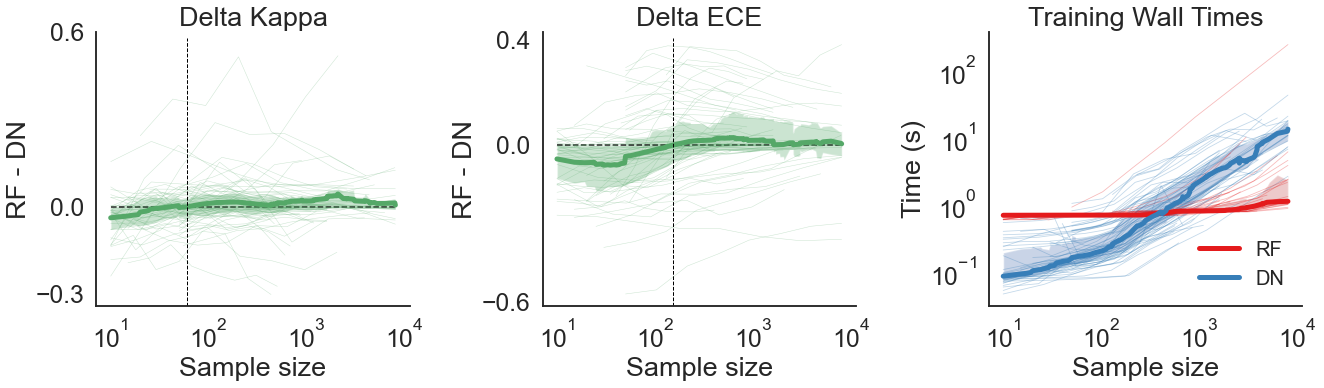

In [4]:
# Set color palette
sns.set(color_codes=True, style="white", context="talk", font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=9)
fig = plt.figure(figsize=(19, 6))

# Subplot 1
ax = plt.subplot(131)

samples = list(np.sort(np.unique(full_dataset_all_sample_sizes)))

kappa_over_dataset = []

total_sets = full_dataset_rf_scores_kappa.shape[0] / 8
rfdn_difference = np.zeros((int(total_sets), 8))

for dataset in range(int(total_sets)):
    rf = full_dataset_rf_scores_kappa[dataset * 8 : dataset * 8 + 8, :]
    dn = full_dataset_dn_scores_kappa[dataset * 8 : dataset * 8 + 8, :]

    dn_evolution_mean = np.mean(dn, axis=1)
    rf_evolution_mean = np.mean(rf, axis=1)

    rfdn_diff = rf_evolution_mean - dn_evolution_mean
    rfdn_difference[dataset, :] = rfdn_diff

    sample_ = list(full_dataset_all_sample_sizes[dataset, :])
    interp_func_kappa = interp1d(
        full_dataset_all_sample_sizes[dataset], rfdn_difference[dataset, :]
    )
    interpolated_kappa = np.array([np.nan] * len(samples))
    interpolated_kappa_ = interp_func_kappa(
        np.array(samples)[
            np.where((samples >= sample_[0]) & (samples <= sample_[-1]))[0]
        ]
    )
    interpolated_kappa[
        np.where((samples >= sample_[0]) & (samples <= sample_[-1]))[0]
    ] = interpolated_kappa_
    kappa_over_dataset.append(interpolated_kappa)

median_vals = np.median(rfdn_difference, axis=0)

for difference in range(int(total_sets)):
    ax.plot(
        full_dataset_all_sample_sizes[difference],
        rfdn_difference[difference, :],
        c="g",
        alpha=0.3,
        lw=0.5,
    )
    ax.set_xlabel("Sample size")
    ax.set_ylabel("RF - DN")
    ax.set_xscale("log")
    ax.set_title("Delta Kappa")
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)

ax.hlines(0, 10, np.max(samples), colors="k", linestyles="dashed", linewidth=1.5)

qunatiles = np.nanquantile(kappa_over_dataset, [0.25, 0.75], axis=0)
ax.fill_between(samples, qunatiles[0], qunatiles[1], facecolor="g", alpha=0.3)
ax.plot(samples, np.nanmean(kappa_over_dataset, axis=0), c="g", lw=5)

vert_line_index = np.where(np.nanmean(kappa_over_dataset, axis=0) < 0)[0][-1]
vert_line = samples[vert_line_index]
ax.axvline(x=vert_line, ymax=0.98, linestyle="--", color="black", linewidth=1)

ylims = ax.get_ylim()
plt.yticks([np.round(ylims[0], 1), 0, np.round(ylims[1], 1)])
plt.xticks([1e1, 1e2, 1e3, 1e4])

# fig.text(0.23, 0.73, "RF wins", ha="center", fontsize=18)
# fig.text(0.120, 0.73, "DN wins", ha="center", fontsize=18)


# Subplot 2
ax = plt.subplot(132)

ece_over_dataset = []

total_sets = full_dataset_rf_scores_ece.shape[0] / 8
rfdn_difference = np.zeros((int(total_sets), 8))

for dataset in range(int(total_sets)):
    rf = full_dataset_rf_scores_ece[dataset * 8 : dataset * 8 + 8, :]
    dn = full_dataset_dn_scores_ece[dataset * 8 : dataset * 8 + 8, :]

    dn_evolution_mean = np.mean(dn, axis=1)
    rf_evolution_mean = np.mean(rf, axis=1)

    rfdn_diff = rf_evolution_mean - dn_evolution_mean
    rfdn_difference[dataset, :] = rfdn_diff

    sample_ = list(full_dataset_all_sample_sizes[dataset, :])
    interp_func_kappa = interp1d(
        full_dataset_all_sample_sizes[dataset], rfdn_difference[dataset, :]
    )
    interpolated_kappa = np.array([np.nan] * len(samples))
    interpolated_kappa_ = interp_func_kappa(
        np.array(samples)[
            np.where((samples >= sample_[0]) & (samples <= sample_[-1]))[0]
        ]
    )
    interpolated_kappa[
        np.where((samples >= sample_[0]) & (samples <= sample_[-1]))[0]
    ] = interpolated_kappa_
    ece_over_dataset.append(interpolated_kappa)

median_vals = np.median(rfdn_difference, axis=0)

for difference in range(int(total_sets)):
    ax.plot(
        full_dataset_all_sample_sizes[difference],
        rfdn_difference[difference, :],
        c="g",
        alpha=0.3,
        lw=0.5,
    )
    ax.set_xlabel("Sample size")
    ax.set_ylabel("RF - DN")
    ax.set_xscale("log")
    ax.set_title("Delta ECE")
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)

ax.hlines(0, 10, np.max(samples), colors="k", linestyles="dashed", linewidth=1.5)

qunatiles = np.nanquantile(ece_over_dataset, [0.25, 0.75], axis=0)
ax.fill_between(samples, qunatiles[0], qunatiles[1], facecolor="g", alpha=0.3)
ax.plot(samples, np.nanmean(ece_over_dataset, axis=0), c="g", lw=5)

vert_line_index = np.where(np.nanmean(ece_over_dataset, axis=0) < 0)[0][-1]
vert_line = samples[vert_line_index]
ax.axvline(x=vert_line, ymax=0.98, linestyle="--", color="black", linewidth=1)

ylims = ax.get_ylim()
plt.yticks([np.round(ylims[0], 1), 0, np.round(ylims[1], 1)])
plt.xticks([1e1, 1e2, 1e3, 1e4])

# fig.text(0.455, 0.73, "RF wins", ha="center", fontsize=18)
# fig.text(0.58, 0.73, "DN wins", ha="center", fontsize=18)


# Subplot 3
ax = plt.subplot(133)

times_over_dataset_rf = []
times_over_dataset_dn = []

total_sets = rf_times_train.shape[0] / 8
rf_times_tot = np.zeros((int(total_sets), 8))
dn_times_tot = np.zeros((int(total_sets), 8))

for dataset in range(int(total_sets)):
    rf = rf_times_train[dataset * 8 : dataset * 8 + 8, :]
    dn = dn_times_train[dataset * 8 : dataset * 8 + 8, :]

    dn_times_mean = np.median(dn, axis=1)
    rf_times_mean = np.median(rf, axis=1)

    dn_times_tot[dataset, :] = dn_times_mean
    rf_times_tot[dataset, :] = rf_times_mean

    sample_ = list(full_dataset_all_sample_sizes[dataset, :])
    interp_func_kappa = interp1d(
        full_dataset_all_sample_sizes[dataset], rf_times_tot[dataset, :]
    )
    interpolated_kappa = np.array([np.nan] * len(samples))
    interpolated_kappa_ = interp_func_kappa(
        np.array(samples)[
            np.where((samples >= sample_[0]) & (samples <= sample_[-1]))[0]
        ]
    )
    interpolated_kappa[
        np.where((samples >= sample_[0]) & (samples <= sample_[-1]))[0]
    ] = interpolated_kappa_
    times_over_dataset_rf.append(interpolated_kappa)

    sample_ = list(full_dataset_all_sample_sizes[dataset, :])
    interp_func_kappa = interp1d(
        full_dataset_all_sample_sizes[dataset], dn_times_tot[dataset, :]
    )
    interpolated_kappa = np.array([np.nan] * len(samples))
    interpolated_kappa_ = interp_func_kappa(
        np.array(samples)[
            np.where((samples >= sample_[0]) & (samples <= sample_[-1]))[0]
        ]
    )
    interpolated_kappa[
        np.where((samples >= sample_[0]) & (samples <= sample_[-1]))[0]
    ] = interpolated_kappa_
    times_over_dataset_dn.append(interpolated_kappa)


median_vals_rf = np.median(rf_times_tot, axis=0)
median_vals_dn = np.median(dn_times_tot, axis=0)


for difference in range(int(total_sets)):
    ax.plot(
        full_dataset_all_sample_sizes[difference],
        rf_times_tot[difference, :],
        c="#e41a1c",
        alpha=0.3,
        lw=0.8,
    )
    ax.plot(
        full_dataset_all_sample_sizes[difference],
        dn_times_tot[difference, :],
        c="#377eb8",
        alpha=0.3,
        lw=0.8,
    )
    ax.set_xlabel("Sample size")
    ax.set_ylabel("Time (s)")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title("Training Wall Times")
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)

ax.hlines(0, 10, np.max(samples), colors="k", linestyles="dashed", linewidth=1.5)

qunatiles = np.nanquantile(times_over_dataset_rf, [0.25, 0.75], axis=0)
ax.fill_between(samples, qunatiles[0], qunatiles[1], facecolor="r", alpha=0.3)
ax.plot(
    samples,
    np.nanmedian(times_over_dataset_rf, axis=0),
    c="#e41a1c",
    lw=5,
    label="RF",
)

qunatiles = np.nanquantile(times_over_dataset_dn, [0.25, 0.75], axis=0)
ax.fill_between(samples, qunatiles[0], qunatiles[1], facecolor="b", alpha=0.3)
ax.plot(
    samples,
    np.nanmedian(times_over_dataset_dn, axis=0),
    c="#377eb8",
    lw=5,
    label="DN",
)

ax.legend(fontsize=20, loc="lower right", frameon=False)
plt.tight_layout()
plt.xticks([1e1, 1e2, 1e3, 1e4])
plt.savefig("../paper/figures/cc18.pdf", transparent=True, bbox_inches="tight")

### RF/DN Scatter Plot

- Column 1 visualizes the relationship between kappa and features for both models. 

- Column 2 visualizes the relationship between train time and features for both models. 

- Column 3 visualizes the relationship between test time and features for both models. 

- Column 4 visualizes the relationship between kappa and number of classes for both models.

Each row represents a bin grouping a certain number of samples. Treadlines for RF and DN models are plotted using linear regression.

In [5]:
# Load in data on dataset classes and dimensions
X_data_list, y_data_list, dataset_name = load_cc18()

dimensions = np.zeros(576)
classes = np.zeros(576)
for i in range(len(X_data_list)):
    dimensions[i * 8 : i * 8 + 8] = X_data_list[i].shape[1]
    classes[i * 8 : i * 8 + 8] = len(np.unique(y_data_list[i]))

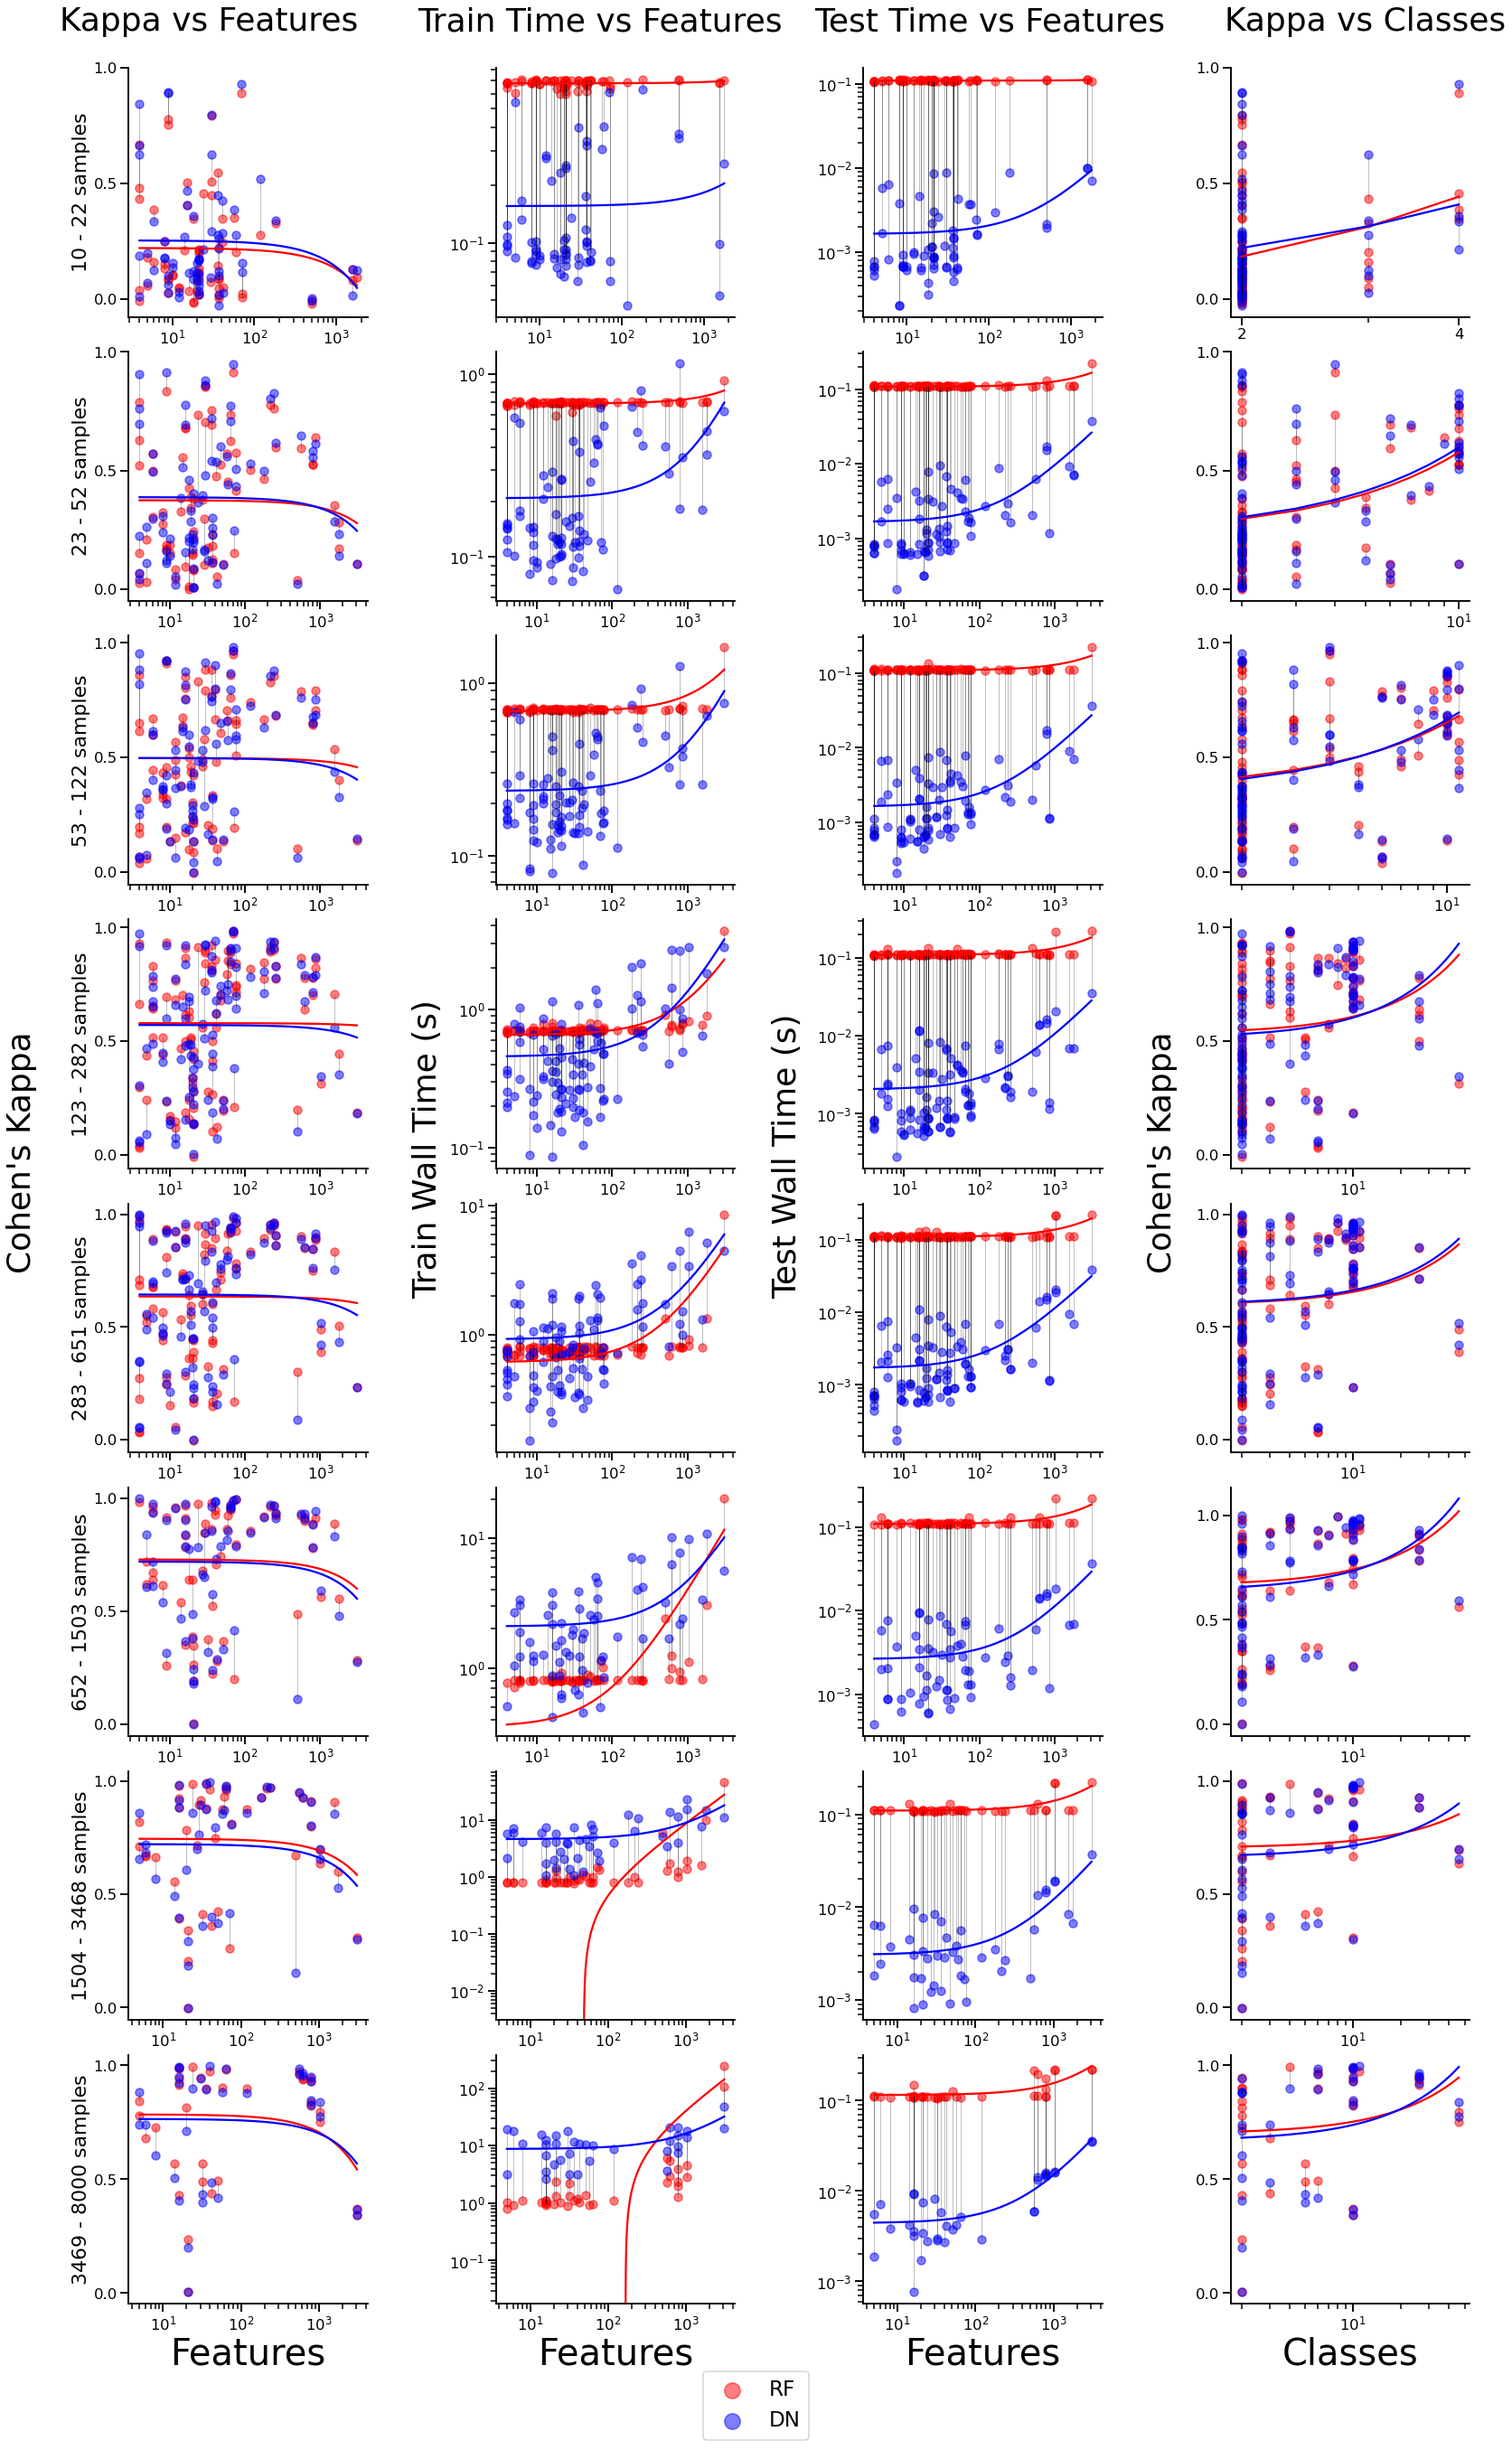

In [6]:
# Set color palette
sns.set_context("talk")
fig, ax = plt.subplots(nrows=8, ncols=3, sharex=True, sharey=True, figsize=(24, 38))

# Set bins to group sample sizes
baskets = [10, 23, 53, 123, 283, 652, 1504, 3469, 8001]

ordered_sample_sizes = full_dataset_all_sample_sizes.reshape(576)

# Average data across runs and index into arrays
scaled_rf_kappa = np.zeros((576, 2))
scaled_dn_kappa = np.zeros((576, 2))
scaled_rf_time_train = np.zeros((576, 2))
scaled_dn_time_train = np.zeros((576, 2))
scaled_rf_time_test = np.zeros((576, 2))
scaled_dn_time_test = np.zeros((576, 2))

for i, key in enumerate(ordered_sample_sizes):
    scaled_rf_kappa[i, :] = [key, np.mean(full_dataset_rf_scores_kappa[i])]
    scaled_dn_kappa[i, :] = [key, np.mean(full_dataset_dn_scores_kappa[i])]
    scaled_rf_time_train[i, :] = [key, np.mean(rf_times_train[i])]
    scaled_dn_time_train[i, :] = [key, np.mean(dn_times_train[i])]
    scaled_rf_time_test[i, :] = [key, np.mean(rf_times_test[i])]
    scaled_dn_time_test[i, :] = [key, np.mean(dn_times_test[i])]


# Generate figure
for plot in range(8):
    runs = np.where(
        (scaled_rf_kappa[:, 0] >= baskets[plot])
        & (scaled_rf_kappa[:, 0] < baskets[plot + 1])
    )
    rf = scaled_rf_kappa[runs][:, 1]
    dn = scaled_dn_kappa[runs][:, 1]
    rft_train = scaled_rf_time_train[runs][:, 1]
    dnt_train = scaled_dn_time_train[runs][:, 1]
    rft_test = scaled_rf_time_test[runs][:, 1]
    dnt_test = scaled_dn_time_test[runs][:, 1]
    dim = dimensions[runs]
    clas = classes[runs]

    # Subplot column 1
    ax = plt.subplot(8, 4, plot * 4 + 1)

    plt.scatter(dim, rf, c="r", alpha=0.5, label="RF")
    plt.scatter(dim, dn, c="b", alpha=0.5, label="DN")

    for ind in range(len(rf)):
        plt.plot([dim[ind], dim[ind]], [rf[ind], dn[ind]], lw=0.5, c="black", alpha=0.5)

    x_int_max = int(max(dim))
    x_int_min = int(min(dim))

    coeffs = np.polyfit(dim, rf, deg=1)
    x_ints = [i for i in range(x_int_min, x_int_max + 1)]
    predict = np.poly1d(coeffs)
    y_ints = predict(x_ints)
    plt.plot(x_ints, y_ints, c="r")

    coeffs = np.polyfit(dim, dn, deg=1)
    x_ints = [i for i in range(x_int_min, x_int_max + 1)]
    predict = np.poly1d(coeffs)
    y_ints = predict(x_ints)
    plt.plot(x_ints, y_ints, c="b")

    ax.set_ylabel(
        "{} - {} samples".format(baskets[plot], baskets[plot + 1] - 1), fontsize=22
    )

    if plot == 7:
        ax.set_xlabel("Features", fontsize=40)
    ax.set_xscale("log")
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)
    ax.set_yticks([0, 0.5, 1.0])

    # Subplot column 2
    ax2 = plt.subplot(8, 4, plot * 4 + 2)

    plt.scatter(dim, rft_train, c="r", alpha=0.5, label="RF")
    plt.scatter(dim, dnt_train, c="b", alpha=0.5, label="DN")

    for ind in range(len(rft_train)):
        plt.plot(
            [dim[ind], dim[ind]],
            [rft_train[ind], dnt_train[ind]],
            lw=0.5,
            c="black",
            alpha=0.5,
        )

    x_int_max = int(max(dim))
    x_int_min = int(min(dim))

    coeffs = np.polyfit(dim, rft_train, deg=1)
    x_ints = [i for i in range(x_int_min, x_int_max + 1)]
    predict = np.poly1d(coeffs)
    y_ints = predict(x_ints)
    plt.plot(x_ints, y_ints, c="r")

    coeffs = np.polyfit(dim, dnt_train, deg=1)
    x_ints = [i for i in range(x_int_min, x_int_max + 1)]
    predict = np.poly1d(coeffs)
    y_ints = predict(x_ints)
    plt.plot(x_ints, y_ints, c="b")

    if plot == 7:
        ax2.set_xlabel("Features", fontsize=40)
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    right_side = ax2.spines["right"]
    right_side.set_visible(False)
    top_side = ax2.spines["top"]
    top_side.set_visible(False)

    # Subplot column 3
    ax2 = plt.subplot(8, 4, plot * 4 + 3)

    plt.scatter(dim, rft_test, c="r", alpha=0.5, label="RF")
    plt.scatter(dim, dnt_test, c="b", alpha=0.5, label="DN")

    for ind in range(len(rft_train)):
        plt.plot(
            [dim[ind], dim[ind]],
            [rft_test[ind], dnt_test[ind]],
            lw=0.5,
            c="black",
            alpha=0.5,
        )

    x_int_max = int(max(dim))
    x_int_min = int(min(dim))

    coeffs = np.polyfit(dim, rft_test, deg=1)
    x_ints = [i for i in range(x_int_min, x_int_max + 1)]
    predict = np.poly1d(coeffs)
    y_ints = predict(x_ints)
    plt.plot(x_ints, y_ints, c="r")

    coeffs = np.polyfit(dim, dnt_test, deg=1)
    x_ints = [i for i in range(x_int_min, x_int_max + 1)]
    predict = np.poly1d(coeffs)
    y_ints = predict(x_ints)
    plt.plot(x_ints, y_ints, c="b")

    if plot == 7:
        ax2.set_xlabel("Features", fontsize=40)
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    right_side = ax2.spines["right"]
    right_side.set_visible(False)
    top_side = ax2.spines["top"]
    top_side.set_visible(False)

    # Subplot column 4
    ax = plt.subplot(8, 4, plot * 4 + 4)

    plt.scatter(clas, rf, c="r", alpha=0.5, label="RF")
    plt.scatter(clas, dn, c="b", alpha=0.5, label="DN")

    for ind in range(len(rft_train)):
        plt.plot(
            [clas[ind], clas[ind]], [rf[ind], dn[ind]], lw=0.5, c="black", alpha=0.5
        )

    x_int_max = int(max(clas))
    x_int_min = int(min(clas))

    coeffs = np.polyfit(clas, rf, deg=1)
    x_ints = [i for i in range(x_int_min, x_int_max + 1)]
    predict = np.poly1d(coeffs)
    y_ints = predict(x_ints)
    plt.plot(x_ints, y_ints, c="r")

    coeffs = np.polyfit(clas, dn, deg=1)
    x_ints = [i for i in range(x_int_min, x_int_max + 1)]
    predict = np.poly1d(coeffs)
    y_ints = predict(x_ints)
    plt.plot(x_ints, y_ints, c="b")

    ax.set_xscale("log")
    if plot == 0:
        ax.set_xticks([2, 4])
        ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
        ax.xaxis.set_minor_formatter(NullFormatter())
    if plot == 1:
        ax.xaxis.set_minor_formatter(NullFormatter())
    if plot == 2:
        ax.xaxis.set_minor_formatter(NullFormatter())
    if plot == 7:
        ax.set_xlabel("Classes", fontsize=40)

    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)
    ax.set_yticks([0, 0.5, 1.0])


fig.text(0.02, 0.48, "Cohen's Kappa", ha="center", fontsize=36, rotation="vertical")
fig.text(
    0.28, 0.47, "Train Wall Time (s)", ha="center", fontsize=36, rotation="vertical"
)
fig.text(
    0.51, 0.47, "Test Wall Time (s)", ha="center", fontsize=36, rotation="vertical"
)
fig.text(0.75, 0.48, "Cohen's Kappa", ha="center", fontsize=36, rotation="vertical")

fig.text(0.14, 0.98, "Kappa vs Features", ha="center", fontsize=36)
fig.text(0.39, 0.98, "Train Time vs Features", ha="center", fontsize=36)
fig.text(0.64, 0.98, "Test Time vs Features", ha="center", fontsize=36)
fig.text(0.88, 0.98, "Kappa vs Classes", ha="center", fontsize=36)

handles, labels = ax.get_legend_handles_labels()
lgnd = fig.legend(handles, labels, loc="lower center", fontsize=23)
lgnd.legendHandles[0]._sizes = [300]
lgnd.legendHandles[1]._sizes = [300]

plt.tight_layout(pad=5, w_pad=5, h_pad=0)